# Example - M100 Fluke Training 
> **On the AM0.1-FLUKE dataset**   
> Train dataset on a google Colab instance  
> Run training of model AM0.1 on fluke dataset, from Claire, markupup by Stacey  
> This dataset has  has 354 800 pixel row images images at ~ rpi 1/2 resolution  
> These are cropped into  ~ 522 images  200 x 200 pixel size  
**[Run this file online in Colab](https://colab.research.google.com/github/johnnewto/cellsegment/blob/master/nbs/21_training_M100_fluke_colab.ipynb)**

In [14]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
IN_COLAB = in_colab()


In [15]:
import os
#hide
if IN_COLAB:
    print('Cloning the cellsegment library')
    os.system('mkdir -p /root/.torch/models')
    os.system('mkdir -p /root/.fastai/data')
    os.system('ln -s /root/.torch/models /content')
    os.system('ln -s /root/.fastai/data /content')
    os.system('rm -rf /content/sample_data/')


## Setup

### Imports

In [43]:
from cellsegment.core import *
from cellsegment.dataprep_utils import *
from cellsegment.inference_utils import *
from cellsegment.set_directories import *
import pandas
from fastai import *
from fastai.vision import *

### Define directories

In [13]:
dirs = Dirs('data') if IN_COLAB else Dirs('../testdata/')
print(dirs)


None
  basepath        :  ../testdata/         
  crop            :  ../testdata//Crop-200 
  cropLabel       :  ../testdata//Crop-200/Label 
  cropTest        :  ../testdata//Crop-200/Test 
  cropTrain       :  ../testdata//Crop-200/Train 
  cropValidTxtFile:  ../testdata//Crop-200/valid.txt 
  label           :  ../testdata//Fullsize/Label 
  model           :  ../testdata//models/ 
  originImages    :  ../testdata//Original 
  sizeCsvFile     :  ../testdata//file_size.csv 
  test            :  ../testdata//Fullsize/Test 
  train           :  ../testdata//Fullsize/Train 
  validTxtFile    :  ../testdata//Fullsize/valid.txt 



In [0]:
#! pip install fastai==1.0.57 

In [21]:
! pip freeze | grep 'fastai\|torch*'    
    
# the following liberies are known to work
# fastai==1.0.57
# torch==1.1.0
# torchvision==0.3.0

fastai==1.0.55
torch==1.1.0
torchsummary==1.5.1
torchvision==0.3.0


In [0]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    data_dir = "/content/drive/My Drive/Colab Notebooks/Tection/data"


## Dataprep - optional, if not alread done

### Load the Training Images

In [17]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit 

    export fileid=1SEW0Kf1CI4e4-up4TGsDqwDwVk_QZEUf
    export filename=Fluke-Train-2019-12-01.zip

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
    
    unzip -u -q $filename -d data


In [18]:
file_csv = dirs.basepath+'/file_data.csv'
fnames = sorted(get_image_files(dirs.train))
fnames = [fn.name for fn in fnames]
df = pandas.DataFrame(fnames)
df.columns = ['Name']
df.to_csv(file_csv, index=False)

In [47]:
! rm -r /content/data/Crop-200

rm: cannot remove '/content/data/Cropy-200': No such file or directory


### Shuffle and Split file list  into train, valid catagories

In [ ]:
shuffle_csv(file_csv,random_state=23)
split_filenames(file_csv, num_train=0.7, num_val=0.15)

### Crop the image files based on json file centers

In [20]:
misslist, croplist= crop_img_dir(dirs.basepath+'/file_data.csv', 
                                              dirs.train, dirs.train, dirs.crop, 
                                              number_files='all', DEBUG=False)
print(f'Num Missed: {len(misslist)}, Num Cropped: {len(croplist)}')

20 files to process in ../testdata/Fullsize/Train
::::::::::::::::::::
Missed 0 and  Cropped 27 files in ../testdata/Crop-200
Num Missed: 0, Num Cropped: 27


### Make crop file list and valid file list, save as csv and txt files

In [40]:
crop_df = pd.DataFrame(croplist)
crop_df = crop_df[['Name','Label', 'Op']]

# relabel with text
crop_df.loc[crop_df.Label == '40','Label'] = 'Fluke-Rumen'
crop_df.loc[crop_df.Label == '11','Label'] = 'Fluke-Liver'
crop_df.to_csv(dirs.crop+'/crop_df.csv', index=False)

crop_df.tail(10)

Name        Label     Op
17  235443 - 21-0.jpg  Fluke-Liver  Train
18  235443 - 21-1.jpg  Fluke-Liver  Train
19  235443 - 21-2.jpg  Fluke-Liver  Train
20   235443 - 7-0.jpg  Fluke-Liver  Valid
21   235443 - 8-0.jpg  Fluke-Liver  Valid
22   235443 - 8-1.jpg  Fluke-Liver  Valid
23  235443 - 18-0.jpg  Fluke-Liver  Valid
24  235443 - 17-0.jpg  Fluke-Liver   Test
25  235443 - 15-0.jpg  Fluke-Liver   Test
26   235443 - 9-0.jpg  Fluke-Liver   Test

In [44]:
valid_df = crop_df[crop_df.Op=='Valid'].loc[:,'Name']
valid_df.to_csv(dirs.crop+'/valid.txt', index=False, header=True)
valid_df.head(10)


368    236569 - 29-0.jpg
369    235444 - 14-0.jpg
370    236568 - 78-0.jpg
371    235444 - 39-0.jpg
372    236568 - 61-0.jpg
373     236567 - 5-0.jpg
374     236567 - 5-1.jpg
375     236567 - 5-2.jpg
376    236568 - 80-0.jpg
377     236571 - 1-0.jpg
Name: Name, dtype: object

### Crop the label files based on json file centers

In [45]:
labmisslist, labcroplist = crop_img_dir(file_csv, dirs.train, dirs.label, dirs.crop, number_files='all')
print(f'Num Missed: {len(labmisslist)}, Num Cropped: {len(labcroplist)}')


354 files to process in data/Fullsize/Label
::::::::::::::::::::::::::::::::::::::::::::::::::  50
::::::::::::::::::::::::::::::::::::::::::::::::::  100
::::::::::::::::::::::::::::::::::::::::::::::::::  150
::::::::::::::::::::::::::::::::::::::::::::::::::  200
::::::::::::::::::::::::::::::::::::::::::::::::::  250
::::::::::::::::::::::::::::::::::::::::::::::::::  300
::::::::::::::::::::::::::::::::::::::::::::::::::  350
::::
Missed 0 and  Cropped 526 files in data/Crop-200
Num Missed: 0, Num Cropped: 526


In [42]:
test_df = crop_df[crop_df.Op == 'Test'] 
test_df.to_csv(dirs.crop+'/test_df.csv', index=False)
test_df.tail(10)

Name        Label    Op
24  235443 - 17-0.jpg  Fluke-Liver  Test
25  235443 - 15-0.jpg  Fluke-Liver  Test
26   235443 - 9-0.jpg  Fluke-Liver  Test

### Remove  pallet info from label images as it seems to mess up the dataloader

In [49]:
fnames =  get_image_files(Path(dirs.crop)/'Label')
# fnames = fnames[:3]
for fn in fnames:
    img = np.asarray(PIL.Image.open(fn))
    PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)
print(f'Label files: {len(fnames)} resaved')

Label files: 526 resaved


## Training Section

### Create DataBunch

In [52]:
path_img = dirs.cropTrain
path_lbl = dirs.cropLabel

codes = np.array(['background', '1', '2', '3']);codes

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_label_fn, classes=codes, convert_mode='RGB'))

tfms = get_transforms(flip_vert=True, max_rotate=10, max_zoom=1.1, max_warp=0.2)
if IN_COLAB:
    bs = 60
else:
    bs = 20  
data = (src.transform(tfms, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
print("bs = ", bs)
print(data)

bs =  60
ImageDataBunch;

Train: LabelList (368 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Valid: LabelList (75 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: data/Crop-200/Train;

Test: None


### Show example images


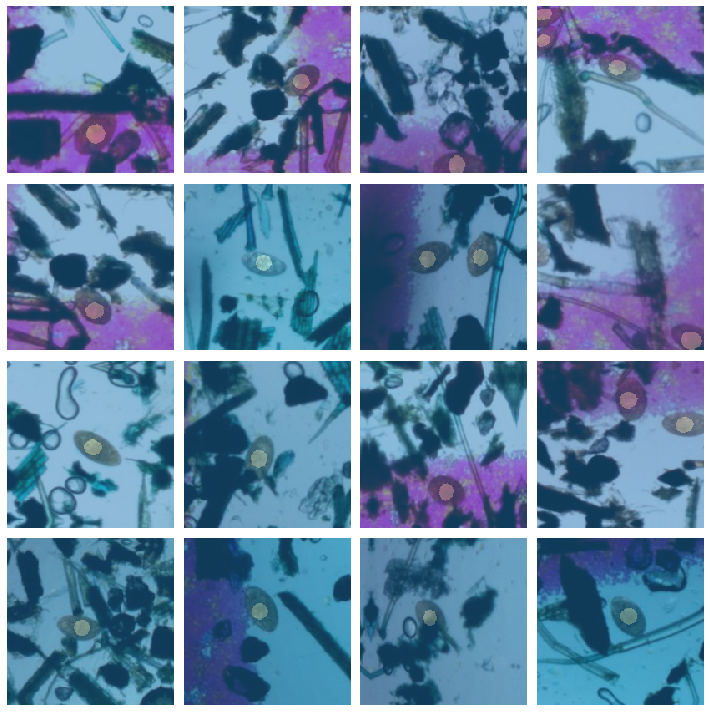

In [53]:
data.show_batch(4, ds_type=DatasetType.Train, figsize=(10,10))

### Learner

In [54]:
# import pdb
# pdb.set_trace()
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]


wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 216MB/s]


### find best learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


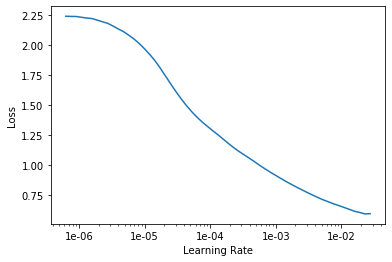

In [55]:
if torch.cuda.is_available():
    learn.lr_find()
    learn.recorder.plot()

### Train Body  for 20 epochs with adam

In [0]:
lr = 3e-3
learn.fit_one_cycle(20, slice(lr))

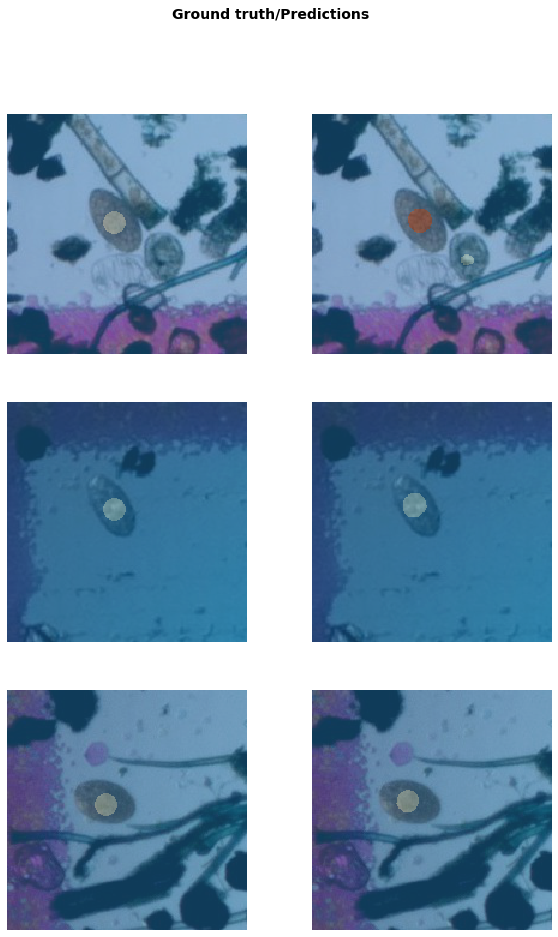

In [0]:
learn.show_results(rows=3, imgsize=5)

In [0]:

learn.save('stage1')

In [0]:
os.rename(learn.data.path/'models/stage1.pth', 'stage1.pth')
! cp 'stage1.pth' 'drive/My Drive/Colab Notebooks/Techion/data/models'

cp: cannot create regular file 'gdrive/My Drive/Colab Notebooks/Techion/data/models': No such file or directory


In [0]:
learn.load('stage1')

### Unfreeze and train body for another 10 cycles

In [0]:
learn.unfreeze()

In [0]:
os.rename(learn.data.path/'models/stage2.pth', 'stage2.pth')
! cp 'stage2.pth' 'drive/My Drive/Colab Notebooks/Techion/data/Fluke'

In [0]:
learn.fit_one_cycle(10, slice(lr/10))

In [0]:
defaults.device = torch.device('cpu')
learn.export('export.pkl')
os.rename(learn.data.path/'export.pkl', 'export-fluke-2019-12-01.pkl')
! cp 'export-fluke-2019-12-01.pkl' 'drive/My Drive/Colab Notebooks/Techion/data/Fluke'



In [0]:
learn.save('stage2')

In [0]:
os.rename(learn.data.path/'models/stage2.pth', 'stage2.pth')
! cp 'stage2.pth' 'drive/My Drive/Colab Notebooks/Techion/data/Fluke'

# Work in Progress - Inference Section

## Load exported Model

In [0]:
%%bash

switch=true
if $switch; then  
    export fileid=11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y
    export filename=export-fluke-2019-11-23.pkl

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3246    0  3246    0     0  13525      0 --:--:-- --:--:-- --:--:-- 13525
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   3260      0 --:--:-- --:--:-- --:--:--  3260
100  114M    0  114M    0     0  56.5M      0 --:--:--  0:00:02 --:--:-- 75.8M
bash: line 22: https://drive.google.com/file/d/1--qQzix86UiXcMh7On6n7oH2GlpJzrqM/view?usp=sharing: No such file or directory
bash: line 23: https://drive.google.com/file/d/11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y/view?usp=sharing: No such file or directory


In [0]:
# defaults.device = 'cpu'
defaults.device = 'cuda'


def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
learn = load_learner('', 'export-fluke.pkl')

learn.model.float()

In [2]:
learn.show_results(rows=5, figsize=(10,20), ds_type=DatasetType.Valid)

NameError: name 'learn' is not defined

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img(im, figsize=None, ax=None, alpha=None, label=None, title=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax

## Run model inference on all of the 78 Test tiles

In [0]:
path = Path('data/Crop-200')
path_img = path/'Train'
path_lbl = path/'Label'
path_tst = path/'Test'

fnames =  get_image_files(path_tst)

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 83


In [0]:
# Plot test images with auto markup labels
def run_inference(fnames, offset=0):
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))
    for i, ax in enumerate(axes.flat):
        if i+offset >= len(fnames): break
        img = open_image(fnames[i+offset])
        pc,pi,o = learn.predict(img)
        show_image(img, ax=ax)
        show_image(pc, ax=ax,  cmap='tab20', alpha=0.5)
        draw_text(ax, (0, 0), fnames[i+offset].stem, color='red')

    plt.tight_layout()

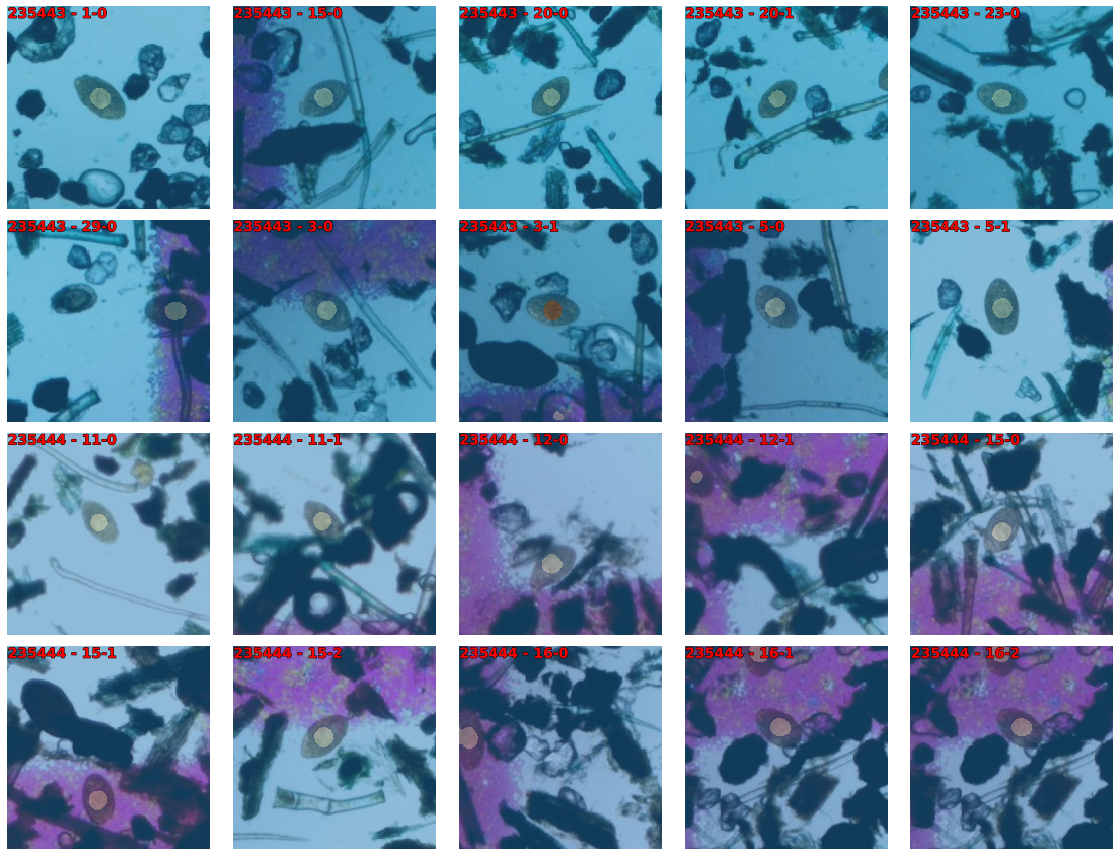

In [0]:
fnames =  sorted(get_image_files(path/'Test'))
run_inference(fnames, offset=0)

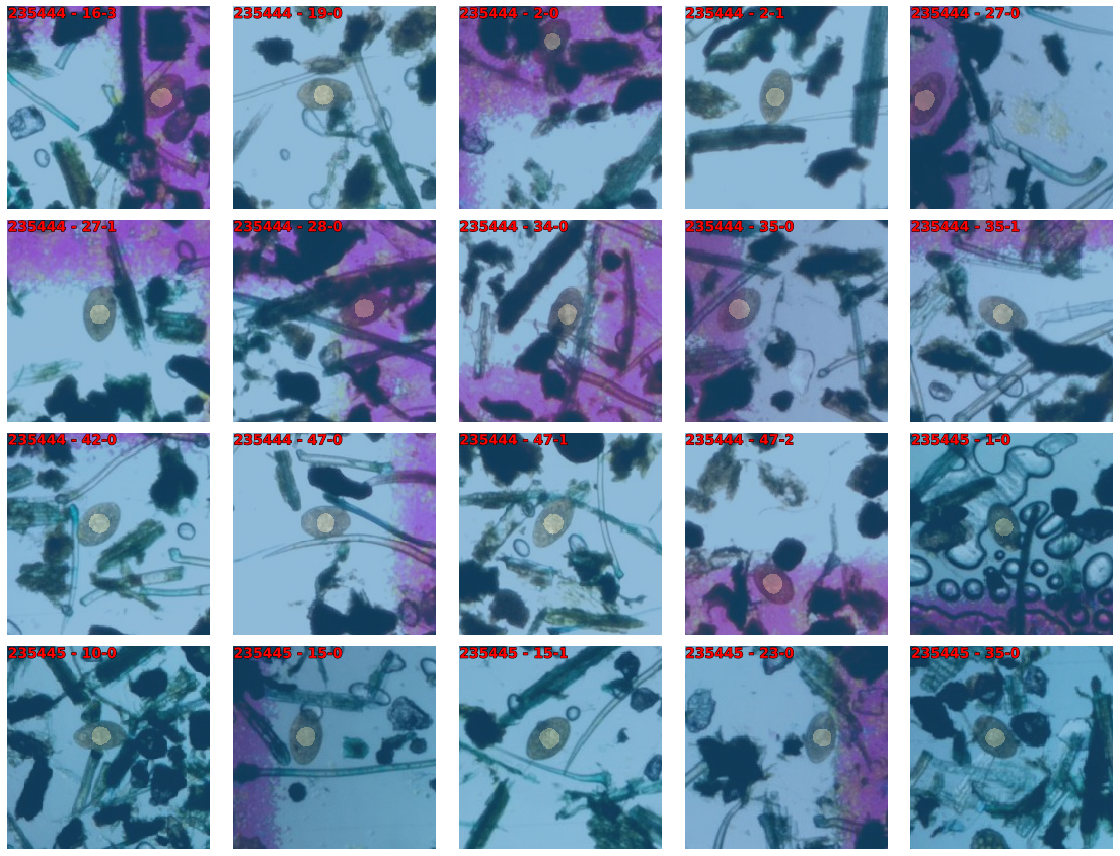

In [0]:
run_inference(fnames, offset=20)

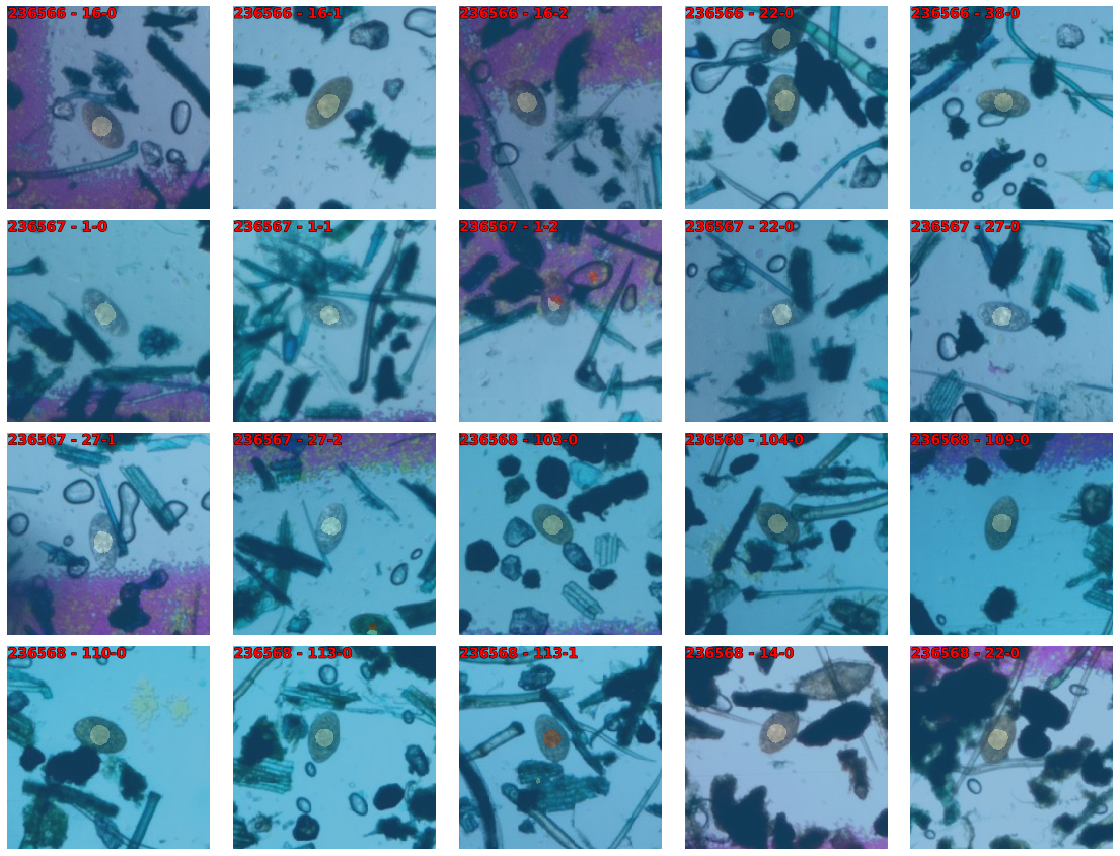

In [0]:
run_inference(fnames, offset=40)

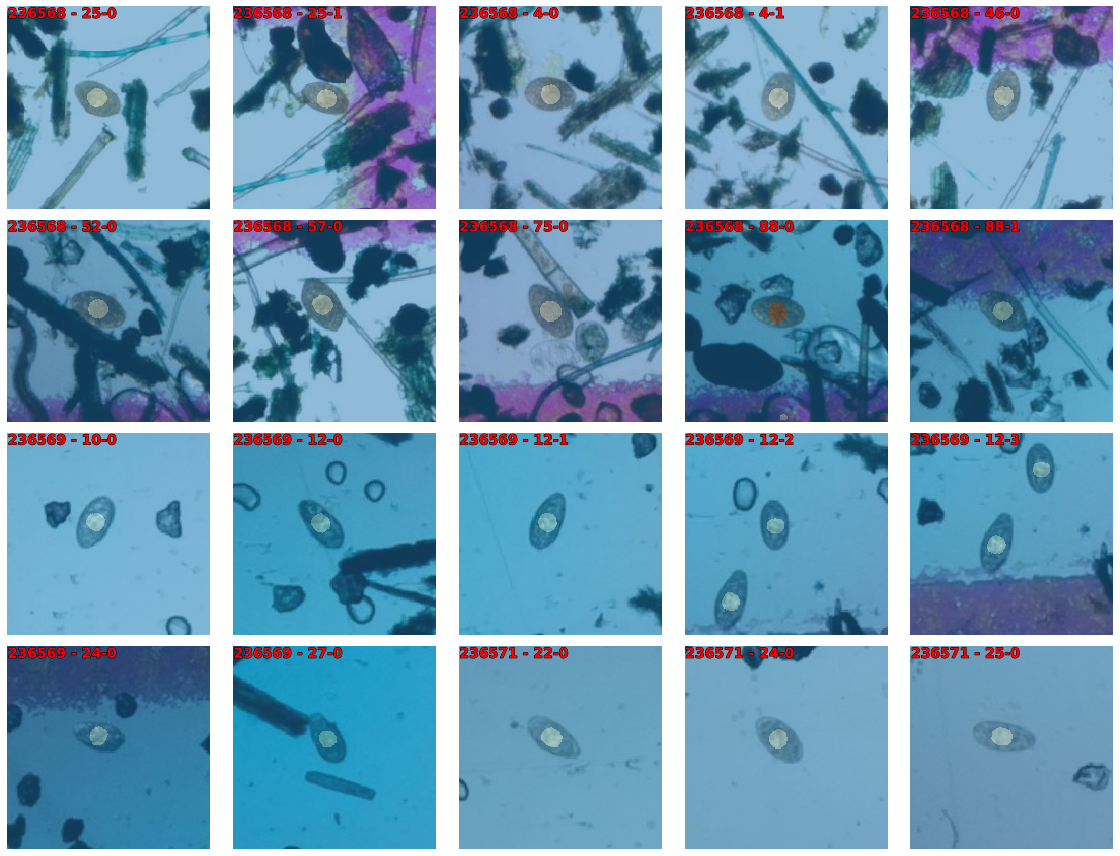

In [0]:
run_inference(fnames, offset=60)

In [0]:
fnames =  sorted(get_image_files(path/'Test'))

# preds= iu.run_inferences(learn, fnames, start=60)
preds= run_inferences(learn, fnames, number_files='all')
len(preds)

83

In [0]:

print(f'Populate dataframe in path {path_tst}')
df = pd.read_csv(path/"test_df.csv")

lst = add_cols_to_probs_df(df)
df.sort_values(by=['Name'])
df.to_csv(path/"test_df.csv", index=False)
df.tail(10)

print(f'Adding inference probs to the dataframe')
probs_to_df(preds, df)   
# df.to_csv(dirs.crop+'/results_df.csv', index=False)
df.sort_values(by=['Name'], inplace=True)

print(f'Find Maximums')
df = pd.read_csv(path/"results_df.csv")
df["max_prob"] = df[["Background", "Fluke_Liver", "Fluke_Rumen"]].max(axis=1)
df.tail(10)
df.loc[df.Fluke_Liver == df.max_prob, "max_prob"] = 'Fluke-Liver'
df.loc[df.Fluke_Rumen == df.max_prob, "max_prob"] = 'Fluke-Rumen'
df.tail(10)
df.to_csv(dirs.crop+'/results_df.csv', index=False)


Populate dataframe in path data/Crop-200/Test
Adding inference probs to the dataframe


/content/techion_expts/library/inference_utils.py:165: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[AAcoords.T.tolist()] = True


Find Maximums


FileNotFoundError: ignored

In [0]:
print(f'Populate dataframe in path {path_tst}')
df = pd.read_csv(path/"test_df.csv")

lst = add_cols_to_probs_df(df)
df.sort_values(by=['Name'])
df.to_csv(path/"test_df.csv", index=False)
df.tail(10)

print(f'Adding inference probs to the dataframe')
probs_to_df(preds, df)   
df.to_csv(dirs.crop+'/results_df.csv', index=False)
df.sort_values(by=['Name'], inplace=True)

print(f'Find Maximums')
df = pd.read_csv(path/"results_df.csv")
df["max_prob"] = df[["Background", "Fluke_Liver", "Fluke_Rumen"]].max(axis=1)
df.tail(10)
df.loc[df.Fluke_Liver == df.max_prob, "max_prob"] = 'Fluke-Liver'
df.loc[df.Fluke_Rumen == df.max_prob, "max_prob"] = 'Fluke-Rumen'
df.tail(10)
df.to_csv(dirs.crop+'/results_df.csv', index=False)


Populate dataframe in path data/Crop-200/Test
Adding inference probs to the dataframe


/content/techion_expts/library/inference_utils.py:165: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[AAcoords.T.tolist()] = True


Find Maximums


KeyError: ignored

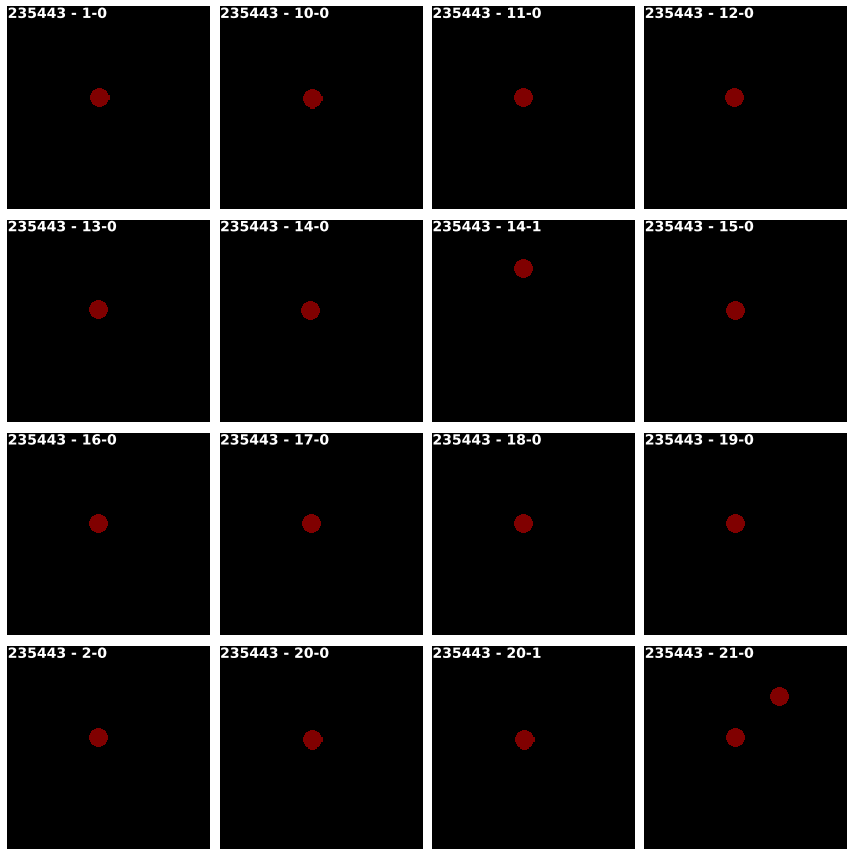

In [0]:
# Plot images and labels
fnames =  sorted(get_image_files(path/'Label'))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = open_image(fnames[i])
    # pc,pi,o = learn.predict(img)
    ax = show_image(img, ax=ax)
    draw_text(ax, (0, 0), fnames[i].stem)

plt.tight_layout()

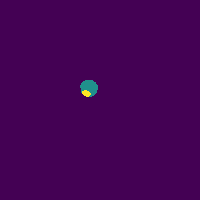

In [0]:
# for fn in fnames:
fnames =  sorted(get_image_files(path/'Test'))
fn = fnames[65]
img = open_image(fn)
pc,pi,o = learn.predict(img)
#     PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)
# print(f'Label files: {len(fnames)} resaved')

pc

In [0]:
o.shape

torch.Size([4, 200, 200])

In [0]:
o

tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 9.9955e-01,
          9.9913e-01, 9.9953e-01],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 9.9982e-01,
          9.9959e-01, 9.9967e-01],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 9.9984e-01,
          9.9994e-01, 9.9989e-01],
         ...,
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00]],

        [[1.4905e-16, 3.0316e-18, 7.4869e-22,  ..., 4.5042e-04,
          8.6764e-04, 4.6169e-04],
         [5.3168e-18, 1.0569e-18, 1.0501e-22,  ..., 1.8189e-04,
          4.0846e-04, 3.3311e-04],
         [4.6862e-22, 1.3364e-23, 4.6182e-24,  ..., 1.6492e-04,
          6.2993e-05, 1.0834e-04],
         ...,
         [1.1409e-11, 1.0678e-11, 5.8950e-10,  ..., 6.1699e-08,
          3.766

In [0]:
# 236569 - 20-0
fnames =  sorted(get_image_files(path/'Test'))
for i , fn in enumerate(fnames):
    print(i, fn)


0 data/Crop-200/Test/235443 - 1-0.jpg
1 data/Crop-200/Test/235443 - 13-0.jpg
2 data/Crop-200/Test/235443 - 15-0.jpg
3 data/Crop-200/Test/235443 - 23-0.jpg
4 data/Crop-200/Test/235443 - 30-0.jpg
5 data/Crop-200/Test/235443 - 4-0.jpg
6 data/Crop-200/Test/235443 - 5-0.jpg
7 data/Crop-200/Test/235443 - 5-1.jpg
8 data/Crop-200/Test/235444 - 27-0.jpg
9 data/Crop-200/Test/235444 - 27-1.jpg
10 data/Crop-200/Test/235444 - 34-0.jpg
11 data/Crop-200/Test/235444 - 39-0.jpg
12 data/Crop-200/Test/235444 - 42-0.jpg
13 data/Crop-200/Test/235445 - 10-0.jpg
14 data/Crop-200/Test/235445 - 15-0.jpg
15 data/Crop-200/Test/235445 - 15-1.jpg
16 data/Crop-200/Test/235445 - 16-0.jpg
17 data/Crop-200/Test/235445 - 2-0.jpg
18 data/Crop-200/Test/235445 - 21-0.jpg
19 data/Crop-200/Test/235445 - 30-0.jpg
20 data/Crop-200/Test/236566 - 2-0.jpg
21 data/Crop-200/Test/236566 - 2-1.jpg
22 data/Crop-200/Test/236566 - 2-2.jpg
23 data/Crop-200/Test/236566 - 24-0.jpg
24 data/Crop-200/Test/236566 - 27-0.jpg
25 data/Crop-200/T

In [0]:
fnames[65]

PosixPath('data/Crop-200/Test/236569 - 20-0.jpg')

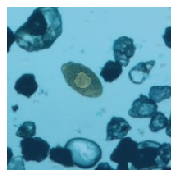

In [0]:
ax = show_image(img)
ax = show_image(pc,ax=ax, cmap='tab20', alpha=0.4)
# im = image2np(pc.cpu())

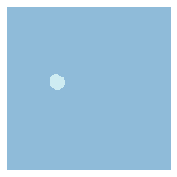

In [0]:
pc.show()

In [0]:
o

## Load Half  Res Exported model

In [0]:
%%bash

switch=true
if $switch; then  
    export fileid=11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y
    export filename=export-fluke.pkl


    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3246    0  3246    0     0  10239      0 --:--:-- --:--:-- --:--:-- 10239
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   2108      0 --:--:-- --:--:-- --:--:--  2097
100  114M    0  114M    0     0  29.5M      0 --:--:--  0:00:03 --:--:-- 50.5M
bash: line 22: https://drive.google.com/file/d/1--qQzix86UiXcMh7On6n7oH2GlpJzrqM/view?usp=sharing: No such file or directory
bash: line 23: https://drive.google.com/file/d/11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y/view?usp=sharing: No such file or directory


In [0]:
# defaults.device = 'cpu'
defaults.device = 'cuda'


def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
learn = load_learner('', 'export-fluke.pkl')

learn.model.float()

## Infer Classes

In [0]:
from fastai import *
from fastai.vision import *
#   import pdb; pdb.set_trace() 

def padImage_t(img, pad=100):
  if pad and pad > 0:
    return F.pad(input=img.px, pad=(pad, pad, pad, pad), mode='constant', value=0)
  else:
    return img

def cut_tiles_t(img, TM=4, TN=4, pad=100):
  M, N = (img.shape[1]-pad*2)//TM, (img.shape[2]-pad*2)//TN 
  OM, ON = pad + M//2, pad + N//2   
  return [Image(img[:,x-OM:x+OM,y-ON:y+ON]) for x in range(pad+M//2,img.shape[1],M) for y in range(pad+N//2,img.shape[2],N)]

def lay_tiles_t(tiles, TM=4, TN=4, pad=100):
  (_,M,N) = tiles[0].size()
  OM, ON = pad + M//2, pad + N//2  
  for n, tile in enumerate(tiles):
    tiles[n] = tile[:,pad:-(pad+1),pad:-(pad+1)]

  hstack = [torch.cat(tiles[y:y+TN],dim=2) for y in range(0,TN*TM,TN)]  
  return torch.cat(hstack,dim=1)


In [0]:
# learn.model.to_fp32()
learn.data.remove_tfm(batch_to_half)

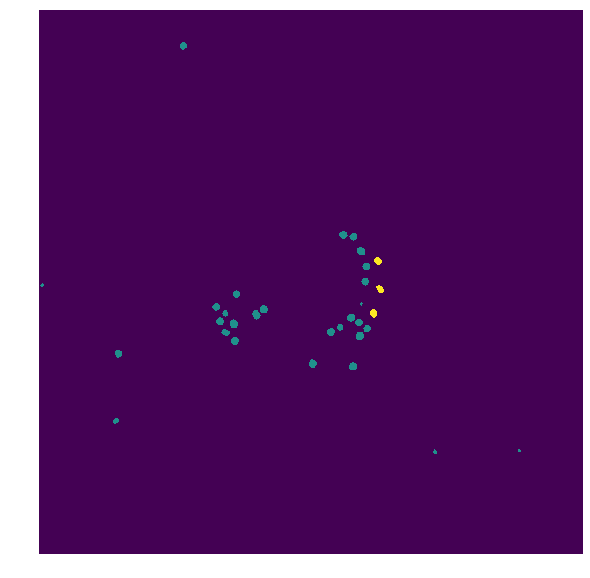

In [0]:
learn.model.float()
# img = open_image('data/images/220972 - 1.jpg').resize(1232)
img = open_image('data/images-half/220968 - 2.jpg')
# img = open_image('data/images/220972 - 1.jpg')

img = padImage_t(img)
tiles = cut_tiles_t(img, TM=2, TN=2, pad=100)

n = len(tiles)
pred_class, pred_idx, outputs = [None]*n, [None]*n, [None]*n
for i, im in enumerate(tiles):
  pc,pi,o = learn.predict(im)  
  pred_class[i] = pc.px

vstack = lay_tiles_t(pred_class, TM=2, TN=2, pad=100)
Image(vstack).show(figsize = (10,10))

## Infer Probabilities

### Generate prediction png file

In [0]:
! rm -r data/images-half-markup 

In [0]:
from fastai import *
from fastai.vision import *
def unet_predict_eggs(fn):
  img = open_image(fn)

  PAD = 100
  TM, TN =2, 2
  img = padImage_t(img, pad=PAD)
  tiles = cut_tiles_t(img, TM=TM, TN=TN, pad=PAD)

  outputs = []
  for i, im in enumerate(tiles):
    pc,pi,o = learn.predict(im)  
    outputs.append(o)

  vstack = lay_tiles_t(outputs, TM=TM, TN=TN, pad=PAD)
  vstack[0,:,:] = vstack[1,:,:]
  vstack[1,:,:] = vstack[2,:,:]
  vstack[2,:,:] = 0
#   vstack[vstack<0.3] = 0
  img = to_np(vstack).transpose(1,2,0)
  return img

def predict_in_image(fn, CONF=0.3):
  pred_img = unet_predict_eggs(fn)
#   predictions = mark_predictions(pred_img, CONF=CONF)
# #   print(predictions)
#   jdata= annotate_json(f'{img_path}/{fn.stem}.json', predictions)

#   mrk_img = np.asarray(PIL.Image.open(fn))
#   mrk_img = draw_labels_cv(mrk_img, jdata, radius=50)
#   return pred_img, mrk_img, jdata
  return pred_img

# img_path = Path('data/images/')
# mrk_path = Path('data/markup/')  

img_path = Path('data/images-half/')
mrk_path = Path('data/images-half-markup/')  
mrk_path.mkdir(parents=True, exist_ok=True)


fnames = sorted(get_image_files(img_path))

# fnames = fnames[600:]
fnames = fnames[-100:]
print(f"Number images to process {len(fnames)}")


for fn in fnames:
  print(fn)
#   pred_img, mrk_img, jdata = predict_in_image(fn) 
  pred_img= predict_in_image(fn) 
  
#   with open(f'{mrk_path}/{fn.stem}.json', 'w') as outfile:
#     json.dump(jdata, outfile, ensure_ascii=False, indent=4)   

  PIL.Image.fromarray((pred_img*255).astype(np.uint8)).save(f'{mrk_path}/{fn.stem}.png')  
#   PIL.Image.fromarray(mrk_img.astype(np.uint8)).save(f'{mrk_path}/{fn.stem}.jpg', quality=90)  
 
#   if len(fnames) < 2:
#     show_img(mrk_img, figsize = (10,10))


Number images to process 100
data/images-half/221578 - 2.jpg


NameError: ignored

In [0]:
%%bash
cd data
# zip -r 'test_images_markup.zip' testimages-markup
zip -r 'markup.zip' markup

In [0]:
# ! mv data/'test_images_markup.zip' '/content/gdrive/My Drive/Colab Notebooks/Techion/data/SecondDataSet'

In [0]:
!ls data
! mv data/markup.zip '/content/gdrive/My Drive/Colab Notebooks/Techion/data/SecondDataSet'

### Class Analyse Predictions

In [0]:
## Class Analyse Predictions
# import pdb; pdb.set_trace()
import cv2
from skimage.measure import label, regionprops
from skimage import filters
from skimage.morphology import erosion, dilation, opening, closing, disk
from scipy.spatial import distance
import pandas as pd
from pandas import DataFrame
# 
# class AnalysePredictions(object):
#     """Methods for preparing and the inference of Well images"""
#     def __init__(self):
#         """What to do here"""
#         self.set_paths();
# 
#     def set_paths(self, base_path=None, img_path=None, mrk_path=None):
#         if base_path is None:
#             base_path = Path().absolute()
#         if img_path is not None:
#             self.img_path = base_path/Path(img_path) 
#             self.mrk_path = base_path/Path(mrk_path)
#         else:
#             self.img_path = Path('data/images/')
#             self.mrk_path = Path('data/markup/')
#         
#     # NP coder for Tile  into  MxN sections to reduce memory footprint
#     def padImage_np(self, img, padding=100):
#       if padding and padding > 0:
#         return np.stack([np.pad(img[:,:,c], padding, mode='constant', constant_values=0) for c in range(3)], axis=2)
#       else:
#         return img
# 
#     def cut_tiles_np(img, TM=4, TN=4, pad=100):
#       M, N = (img.shape[0]-pad*2)//TM, (img.shape[1]-pad*2)//TN 
#       OM, ON = pad + M//2, pad + N//2
#       return [img[x-OM:x+OM,y-ON:y+ON,:] for x in range(pad+M//2,img.shape[0],M) for y in range(pad+N//2,img.shape[1],N)]
# 
#     def lay_tiles_np(self, tiles, TM=4, TN=4, pad=100):
#       OM, ON = pad + M//2, pad + N//2
#       for n, tile in enumerate(tiles):
#         tiles[n] = tile[pad:-pad,pad:-pad,:]
# 
#       hstack = [np.concatenate(tiles[y:y+TN],axis=1) for y in range(0,TN*TM,TN)]  
#       return np.concatenate(hstack,axis=0)
# 
#     def test_tile_np(self):
#         img = to_np(open_image('data/subset/220972 - 1.jpg').resize(800).px).transpose(1,2,0)
#         img = padImage_np(img)
#         tiles = cut_tiles_np(img)
#         vstack = lay_tiles_np(tiles, TM=4, TN=4, pad=100)
#         show_img(vstack, figsize = (10,10))
# 
#     ## Tensor coder for Tile  into  MxN sections to reduce memory footprint
# 
#     def padImage_t(self, img, pad=100):
#       if pad and pad > 0:
#         return F.pad(input=img.px, pad=(pad, pad, pad, pad), mode='constant', value=0)
#       else:
#         return img
# 
#     def cut_tiles_t(self, img, TM=4, TN=4, pad=100):
#       M, N = (img.shape[1]-pad*2)//TM, (img.shape[2]-pad*2)//TN 
#       OM, ON = pad + M//2, pad + N//2  
#       return [Image(img[:,x-OM:x+OM,y-ON:y+ON]) for x in range(pad+M//2,img.shape[1],M) for y in range(pad+N//2,img.shape[2],N)]
# 
#     def lay_tiles_t(self, tiles, TM=4, TN=4, pad=100):
#       (_,M,N) = tiles[0].size()
#       OM, ON = pad + M//2, pad + N//2  
#       for n, tile in enumerate(tiles):
#         tiles[n] = tile[:,pad:-(pad+1),pad:-(pad+1)]
# 
#       hstack = [torch.cat(tiles[y:y+TN],dim=2) for y in range(0,TN*TM,TN)]  
#       return torch.cat(hstack,dim=1)
# 
#     def test_tile_t(self):
#         img = open_image('data/subset/220972 - 1.jpg')
#         # img = to_np(open_image('data/subset/220972 - 1.jpg').resize(800).px).transpose(1,2,0)
#         img = padImage_t(img)
#         tiles = cut_tiles_t(img)
# 
#         for n, tile in enumerate(tiles):
#             tiles[n] = tile.px
#             print(tile.px.shape)
# 
#         vstack = lay_tiles_t(tiles)
#         Image(vstack).show(figsize = (10,10))
# 
#     ## Drawing annotation labels on an image
#     def draw_labels_cv(self, img, json, radius=40):
#       font = cv2.FONT_HERSHEY_SIMPLEX
#       for s, sh in enumerate(json['shapes']):
#         if sh["label"][:3] == "Str":
#           fill = (255,0,0)
#         elif sh["label"][:3] == "Nem":
#           fill = (0,255,0)
#         else:
#           print('[Error]: unknown label')
# 
#         draw = 'None'  
#         if sh['shape_type'] == 'circle':
#           draw = 'circle'
#           probability = str(sh['probability']) if 'probability' in sh else ''
#         elif sh['shape_type'] == 'rectangle':
#           draw = 'rectangle'
#         else:
#           print("Unknown shape_type", sh['shape_type'])
# 
# 
#         xy = np.asarray(sh["points"])
#         ave = np.mean(xy,axis=0)
# 
#         cx = int(ave[0])
#         cy = int(ave[1])
# 
#         if draw == 'circle':
#           cv2.circle(img, (cx, cy), radius, fill, 2)
#           cv2.circle(img, (cx, cy), radius, fill, 2)
#           cv2.putText(img,probability,(int(cx-radius), cy-radius), font, 1, fill, 2, cv2.LINE_AA)
# 
# 
#         elif draw == 'rectangle':
#           cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 2)
# 
#       return img
#     def test_draw_labels_cv(self):
#         img_path = Path('data/subset/')
#         tst_path = Path('data/test/')  
#         tst_path.mkdir(parents=True, exist_ok=True)
#         fn = Path('data/markup/220966 - 1.png')
#         img = np.asarray(PIL.Image.open(fn))
#         _json = json.load(open('data/markup/220966 - 1.json'))
#         mrk_img = draw_labels_cv(img, _json, radius=40) 
#         show_img(mrk_img[:500,1000:1500,:], figsize = (10,10))
#         PIL.Image.fromarray(mrk_img.astype(np.uint8)).save(f'{tst_path}/{fn.stem}.jpg', quality=90) 
# 
#     ## 
#     def find_prediction_blobs(self, img, CONF=0.5, radius=40, plot=False): 
#         # region props seems to have region.max_intensity errors if no data not np.int 
#         SCALE = 100
#         CONF *= SCALE
#         selem = disk(6)
#     #     img = filters.gaussian(img, sigma= 1 / 40, multichannel=True)
#         img = (img * (SCALE/img.max())).astype(np.int)
#         img[img[:,:,0]<CONF,0] = 0
#         img[img[:,:,1]<CONF,1] = 0
#     #     img[:,:,0] = img[:,:,0] > CONF
#     #     img[:,:,1] = img[:,:,1] > CONF
#         predictions = []
#     #     imgL = img[:,:,0].astype(np.int)
#     #     img[:,:,0] = closing(img[:,:,0], selem)
#     #     img[:,:,1] = closing(img[:,:,1], selem)
#     #     img[:,:,0] = opening(img[:,:,0], selem)
#     #     img[:,:,1] = opening(img[:,:,1], selem)
# 
#         fill = (255,0,0)
#         label_image0 = label(img[:,:,0] > CONF)
#         label_image1 = label(img[:,:,1] > CONF)
# 
# #         img = img.copy()  # helped with a cv error?
#         img = np.array(img) # helped with a cv error?
#         for region in regionprops(label_image0, img[:,:,0], cache=True):
#             if region.area > 100:
#                 cx = int(region.centroid[1])
#                 cy = int(region.centroid[0])
# #                 import pdb; pdb.set_trace()
# #                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
#                 predictions.append({"label": 'Strongyle', "point": [cx,cy], "probability": region.max_intensity.round(2)})  
#     #             print(' 0:', [cx,cy], 'area:',  region.area, 
#     #                   'max',  region.max_intensity.round(2), 
#     #                   'mean', region.mean_intensity.round(2))
#         fill = (0,255,0)
#         img = np.array(img) # helped with a cv error?
#         for region in regionprops(label_image1, img[:,:,1]):
#             if region.area > 100:
#                 cx = int(region.centroid[1])
#                 cy = int(region.centroid[0])
# #                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
#                 predictions.append({"label": 'Nematodirus',"point": [cx,cy], "probability": region.max_intensity.round(2)})
#     #             print(f' 1: area {region.area}, max intensity {region.max_intensity.round(5)}')
#     #         #     print(region.area)
#         if plot:
#             #   show_img(imglab, figsize = (15,15))
#             plt.figure(figsize=(15, 15))
#             plt.subplot(121)
#             plt.imshow(label_image0, cmap='nipy_spectral')
#             #   plt.imshow(img[:,:,0] > CONF, cmap='nipy_spectral')
#             plt.axis('off')
#             plt.subplot(122)
#             plt.imshow(label_image1, cmap='nipy_spectral')
#             plt.axis('off')
# 
#             plt.tight_layout()
#             plt.show()
# 
#         return predictions, img
#     def test_find_prediction_blobs(self ): 
#     #     fn = 'data/markup/220966 - 1.png'
#         tst_path = Path('data/test/')
#         fn = Path('data/markup/221221 - 1.png')
#         print(f"Testing: def test_find_prediction_blobs('{fn}'):")
#         img = np.asarray(PIL.Image.open(fn))
# 
# 
#         anno_list, proc_img = find_prediction_blobs(img, plot=True)
#         print("Max value", proc_img.max())
#         PIL.Image.fromarray(proc_img.astype(np.uint8)).save(f'{tst_path}/{fn.stem}.png') 
#     #     print(anno_list)
# 
#     ## Annotate the json file with predictions
#     def annotate_json(self, fn, annotations=None):
#         def add_anno(data, item):
#             r = 40
#             cx,cy = item['point']
#             pnt_list = [[cx-r,cy-r], [cx+r,cy+r]]
# 
#             probability = str(item['probability']) if 'probability' in item else str(0)
# 
#             if item['label'][:3]=='Str': 
#                 line_color = [255,0,0,127]
#                 data['shapes'].append({
#                         "label": item['label'],"line_color": line_color, "fill_color": None,
#                         "points": pnt_list, "shape_type": "circle", 'probability': probability
#             })      
# 
#             elif item['label'][:3]=='Nem': 
#                 line_color = [0,255,0,127]
#                 data['shapes'].append({
#                         "label": item['label'],"line_color": line_color, "fill_color": None,
#                         "points": pnt_list, "shape_type": "circle", 'probability': probability
#                 })
#             else:
#                 print('Unknown label')
# 
#         def add_annotations(data, annotations): 
#             for item in annotations:
#                 add_anno(data, item)
# 
#         def del_circle_annotations(data):
#             to_del = [s for s,sh in enumerate(data['shapes']) if sh['shape_type']=='circle']
#             if len(to_del) > 0: 
#                 print(f'Deleting {len(to_del)} circle annotations')
#             for i in sorted(to_del, reverse=True):
#                 del data['shapes'][i]        
# 
#         data = json.load(open(fn))
#         del_circle_annotations(data)
#         add_annotations(data, annotations) 
#         return data
# 
#     def test_annotate_json(self):  
#       fn = 'data/markup/220966 - 1.png'
#       img = np.asarray(PIL.Image.open(fn))
# 
#       predictions, _ = self.find_prediction_blobs(img, plot=False)
#       print(predictions)
#       data= self.annotate_json('data/subset/220966 - 1.json', predictions)
#       print(data)
#       with open('data/subset/220966 - 1.json', 'w') as outfile:
#         json.dump(data, outfile, ensure_ascii=False, indent=4)   
# 
#     ## Unet Predict classes from a well image
#     def unet_predict_classes(self):
#         fn = 'data/subset/220967 - 1.json'
#         data = json.load(open(fn))
# 
#         ## Infer Classes
# 
#         img = open_image('data/subset/220972 - 1.jpg')
# 
#         img = padImage_t(img)
#         tiles = cut_tiles_t(img)
# 
#         n = len(tiles)
#         pred_class, pred_idx, outputs = [None]*n, [None]*n, [None]*n
#         for i, im in enumerate(tiles):
#           pc,pi,o = learn.predict(im)  
#           pred_class[i] = pc.px
# 
#         vstack = lay_tiles_t(pred_class, TM=4, TN=4, pad=100)
#         Image(vstack).show(figsize = (10,10))
# 
#     ## Infer Probabilities
#     def unet_predict_eggs(self, fn):
#       img = open_image(fn)
# 
#       PAD = 100
#       TM, TN =4, 4
#       img = padImage_t(img, pad=PAD)
#       tiles = cut_tiles_t(img, TM=TM, TN=TN, pad=PAD)
# 
#       outputs = []
#       for i, im in enumerate(tiles):
#         pc,pi,o = learn.predict(im)  
#         outputs.append(o)
# 
#       vstack = lay_tiles_t(outputs, TM=TM, TN=TN, pad=PAD)
#       vstack[0,:,:] = vstack[1,:,:]
#       vstack[1,:,:] = vstack[2,:,:]
#       vstack[2,:,:] = 0
#     #   vstack[vstack<0.3] = 0
#       img = to_np(vstack).transpose(1,2,0)
#       return img
# 
# 
#     ### Generate prediction png file
#     def predict_in_image(self, fn, CONF=0.3):
#       pred_img = unet_predict_eggs(fn)
#       predictions = mark_predictions(pred_img, CONF=CONF)
#     #   print(predictions)
#       jdata= annotate_json(f'{img_path}/{fn.stem}.json', predictions)
# 
#       mrk_img = np.asarray(PIL.Image.open(fn))
#       mrk_img = draw_labels_cv(mrk_img, jdata, radius=50)
#       return pred_img, mrk_img, jdata
# 
#     def markup_image(self, img, CONF=0.5):
#         predictions, _ = self.find_prediction_blobs(img, CONF=CONF)
#         #   print(predictions)
#         jdata= self.annotate_json(f'{self.img_path}/{fn.stem}.json', predictions)
# 
#         mrk_img = np.asarray(PIL.Image.open(f'{img_path}/{fn.stem}.jpg'))
#         mrk_img = self.draw_labels_cv(mrk_img, jdata, radius=50)
#         return mrk_img, jdata
#     
#     def markup_all_images_dir(self, count='all', CONF=0.5):
#         fnames = sorted(get_files(self.mrk_path, '.png'))
#         if count.isdigit(): 
#             fnames = fnames[:count]
#         print(f'Marking up {len(fnames)} images')
# 
#         for n, fn in enumerate(fnames):
# #             print(fn, end=' ')
#             src_img = np.asarray(PIL.Image.open(fn))
#             # find blobs in png            mrk_img, jdata = self.markup_image(img) 
#             predictions, _ = self.find_prediction_blobs(src_img, CONF=CONF)
#             print(len(predictions), end=', ')
#             if n % 20 == 0:
#               print(';')
#     
#             # annotate json
#             jdata= self.annotate_json(f'{self.img_path}/{fn.stem}.json', predictions)
#             with open(f'{self.mrk_path}/{fn.stem}.json', 'w') as outfile:
#                 json.dump(jdata, outfile, ensure_ascii=False, indent=4)   
#             # mark up jpg
#             mrk_img = np.asarray(PIL.Image.open(f'{self.img_path}/{fn.stem}.jpg'))
#             mrk_img = self.draw_labels_cv(mrk_img, jdata, radius=50)
#             PIL.Image.fromarray(mrk_img.astype(np.uint8)).save(f'{self.mrk_path}/{fn.stem}.jpg', quality=90)  
# 
#         return mrk_img
#     
# 
# 
#     def calc_stats_row(self, jdata, radius=30):
#         human = []
#         machine = []
#         for s,sh in enumerate(jdata['shapes']):
#             ave = np.mean(np.asarray(sh["points"]),axis=0).tolist()
#             if sh['shape_type'] == 'rectangle':
#                 human.append(ave)
#             elif sh['shape_type'] == 'circle':
#                 machine.append(ave)
#             else:
#                 print("unknown label", data["imagePath"])
# 
#         if (len(human) > 0) and (len(machine) > 0):
#             dist = distance.cdist(human, machine, 'euclidean')
#             n_human, n_AI, n_match = len(human), len(machine), (np.min(dist, axis=1) < radius).sum()
#         else:
#             n_human, n_AI, n_match = len(human), len(machine), 0
# 
#         row = {
#             'File': jdata["imagePath"],
#             'Num Human': n_human, 
#             'Num AI': n_AI, 
#             'Matched': n_match, 
#             'AI: Un-matched': n_AI - n_match, 
#             'AI: Missed Eggs': n_human - n_match
#         }
# 
#         return row
# 
#     def calc_stats_table(self):
#         # img_path = Path('data/markup')
#     #     mrk_path = Path('data/testimages-markup/')
# 
#         fnames = sorted(get_files(self.mrk_path, '.json'))
# 
#         df = DataFrame (columns = ['File', 'Num Human','Num AI', 'Matched', 'AI: Un-matched', 'AI: Missed Eggs'])
#         fnames = fnames
#         for fn in fnames:
#             data = json.load(open(fn))
#             row = self.calc_stats_row(data, radius=30)
#             df = df.append(row, ignore_index=True)
# 
#         for col in range(1, len(df.columns)):
#             df.iloc[:,col] = pd.to_numeric(df.iloc[:,col])
# 
#         _sum = df.sum(axis = 0, skipna=True, numeric_only=True).rename('Total') 
#         _mean = df.mean(axis = 0, skipna=True, numeric_only=True).rename('Mean') 
# 
#         # df= df.append(df.sum(axis = 0, skipna=True, numeric_only=True).rename('Total')) 
# 
#         # df=df.append(df.mean(axis = 0, skipna=True, numeric_only=True).rename('Mean'))    
#         df = df.append(_mean).append(_sum)
#         return df
#     def plot_piechart(self, df):
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#         colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#         explode = (0.1, 0)  # explode 1st slice
#         labels = 'Matched Eggs', 'AI: Missed Eggs' 
#         sizes = [df.at['Total','Matched'], df.at['Total','AI: Missed Eggs']]
#         axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)
# 
#         labels = 'Matched Eggs', 'AI: Predictions not Matched' 
#         sizes = [df.at['Total','Matched'], df.at['Total','AI: Un-matched']]
#         axes[1].pie(sizes, explode=explode, labels=labels, colors=colors,
#         autopct='%1.1f%%', shadow=True, startangle=140)
#         plt.tight_layout(pad=0.0)
# # pi = AnalysePredictions()
# # print("Start tests:")
# pi.test_annotate_json()
# ii.test_draw_labels_cv()
# ii.test_find_prediction_blobs()

### Run Analysis

Marking up 100 images
10, ;
17, 13, 8, 11, 8, 8, 8, 3, 24, 14, 1, 3, 26, 16, 10, 14, 5, 5, 8, 4, ;
17, 15, 52, 55, 6, 7, 5, 5, 3, 8, 6, 7, 3, 4, 24, 17, 9, 6, 6, 7, ;
10, 12, 18, 23, 24, 13, 2, 2, 8, 7, 10, 7, 37, 31, 10, 5, 13, 14, 15, 17, ;
8, 5, 3, 1, 14, 18, 5, 2, 6, 10, 17, 7, 7, 6, 20, 8, 10, 3, 6, 8, ;
4, 3, 6, 8, 29, 35, 44, 33, 6, 2, 2, 4, 6, 7, 16, 15, 6, 4, 24, 

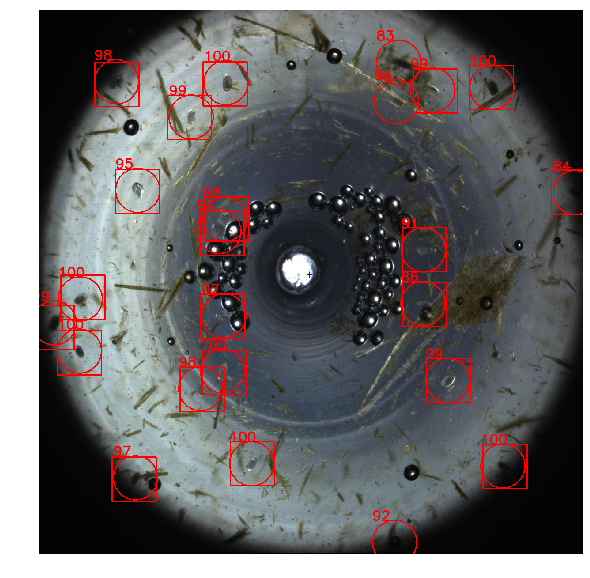

In [0]:
# def show_img(im, figsize=None, ax=None, alpha=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     ax.imshow(im, alpha=alpha)
#     ax.set_axis_off()
#     return ax
# 
# 
# ip = AnalysePredictions()
# ip.set_paths(base_path='', 
#              img_path='data/images-half/', 
#              mrk_path = 'data/images-half-markup/') 
# mrk_img = ip.markup_all_images_dir(count = 'all')
# show_img(mrk_img, figsize = (10,10))

In [0]:
# df = ip.calc_stats_table()
# df.tail(10)

File  Num Human  ...  AI: Un-matched  AI: Missed Eggs
92     221624 - 2.jpg       3.00  ...            1.00             0.00
93     221625 - 1.jpg       5.00  ...            1.00             0.00
94     221625 - 2.jpg       6.00  ...            2.00             1.00
95     221626 - 1.jpg      16.00  ...            1.00             1.00
96     221626 - 2.jpg      16.00  ...            1.00             2.00
97     221627 - 1.jpg       3.00  ...            3.00             0.00
98     221627 - 2.jpg       4.00  ...            1.00             1.00
99     221628 - 1.jpg      21.00  ...            3.00             0.00
Mean              NaN      11.44  ...            1.02             0.72
Total             NaN    1144.00  ...          102.00            72.00

[10 rows x 6 columns]

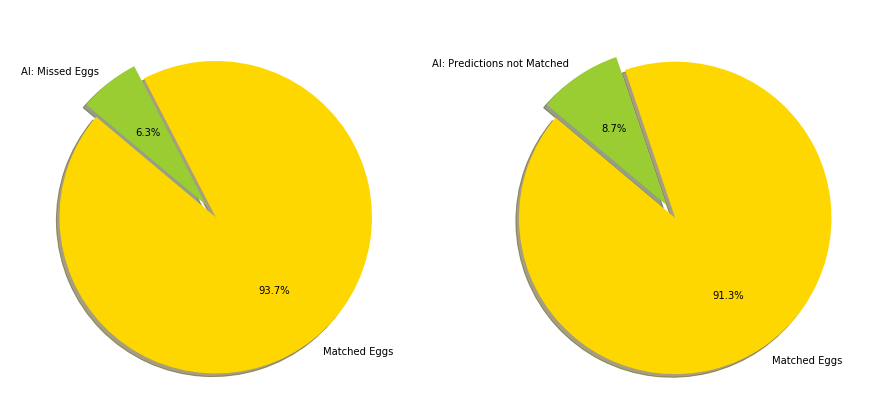

In [0]:
# ip.plot_piechart(df)